<a href="https://colab.research.google.com/github/Mikaner/reinforcement/blob/main/DDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt -qq install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install gym
!pip -q install JSAnimation
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

E: Unable to locate package libcusparse8.0
E: Couldn't find any package by glob 'libcusparse8.0'
E: Couldn't find any package by regex 'libcusparse8.0'
E: Unable to locate package libnvrtc8.0
E: Couldn't find any package by glob 'libnvrtc8.0'
E: Couldn't find any package by regex 'libnvrtc8.0'




In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = f":{display.display}"
# https://github.com/ponty/PyVirtualDisplay/issues/54

In [4]:
# 動画の描画関数の宣言
# 参考URL: http://nbviewer.jupyter.org/github/patrickmineault/xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
#from IPython.display import display
from IPython.display import HTML

def make_anim(frames):
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), 
               dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
    
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),
                                   interval=50)
    return anim

def save_frames_as_gif(frames):
    """
    DISPLAYs a list of frames as a gif, with controls
    """
    
    anim = make_anim(frames)
    anim.save('movie_cartpole_DQN.mp4')
    #display(display_animation(anim, default_mode='loop'))
    return anim.to_jshtml()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym

In [6]:
# namedtupleを生成
from collections import namedtuple

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [7]:
ENV = 'CartPole-v0'
GAMMA = 0.99
MAX_STEPS = 200
NUM_EPISODES = 500

In [8]:
# ミニバッチ学習を実現するために
# 経験を保存するメモリクラスを定義します

class ReplayMemory:
    def __init__(self, CAPACITY):
        self.capacity = CAPACITY
        self.memory = []
        self.index = 0

    def push(self, state, action, state_next, reward):
        '''transition = (state, action, state_next, reward)をメモリに保存する'''

        if len(self.memory) < self.capacity:
            self.memory.append(None) # メモリが満タンでないときは足す
            
        # namedtupleのTransitionを使用し、値とフィールド名をペアにして保存します
        self.memory[self.index] = Transition(state, action, state_next, reward)

        self.index = (self.index + 1) % self.capacity # 保存するindexを1つずらす(最大の場合は最初に上書き)

    def sample(self, batch_size):
        '''batch_size分だけ、ランダムに保存内容を取り出す'''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        '''関数lenに対して、現在の変数memoryの長さを返す'''
        return len(self.memory)

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, n_in, n_mid, n_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, n_mid)
        self.fc2 = nn.Linear(n_mid, n_mid)
        self.fc3 = nn.Linear(n_mid, n_out)

    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        output = self.fc3(h2)
        return output

In [32]:
# エージェントが持つ脳となるクラス。DQNを実行する。
# Q関数をディープラーニングのネットワークをクラスとして定義

import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 32
CAPACITY = 10000  # メモリの最大値(メモリが足りなくなるなんてことがあるのかしら)


class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions # CartPoleの行動(右に左に押す)の2を取得

        # 経験を記憶するメモリオブジェクトを生成
        self.memory = ReplayMemory(CAPACITY)
        
        # ニューラルネットワークを構築
        n_in, n_mid, n_out = num_states, 32, num_actions
        self.main_q_network = Net(n_in, n_mid, n_out)
        self.target_q_network = Net(n_in, n_mid, n_out)
        print(self.main_q_network)
        self.optimizer = optim.Adam(self.main_q_network.parameters(), lr=0.0001)

    def replay(self):
        '''Experience Replayでネットワークの結合パラメータを学習'''

        # -------------------------------------------------
        # 1. メモリサイズの確認
        # -------------------------------------------------
        # 1.1 メモリサイズがミニバッチより小さい間は何もしない
        if len(self.memory) < BATCH_SIZE:
            return
        
        # -------------------------------------------------
        # 2. ミニバッチの作成
        # -------------------------------------------------
        # make_minibatchに関数化
        self.batch, self.state_batch, self.action_batch, self.reward_batch, self.non_final_next_states = self.make_minibatch()
        

        # -------------------------------------------------
        # 3. 教師信号となるQ(s_t, a_t)値を求める
        # -------------------------------------------------
        # get_expected_state_action_valuesに関数化
        self.expected_state_action_values = self.get_expected_state_action_values()

        # -------------------------------------------------
        # 4. 結合パラメータの更新
        # -------------------------------------------------
        # update_main_q_networkに関数化
        self.update_main_q_network()

    def decide_action(self, state, episode):
        ''' 現在の状況に応じて、行動を決定する '''
        # ε-greedy法で徐々に最適行動のみを採用する
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1):
            self.main_q_network.eval() # ネットワークを推論モードに切り替える
            with torch.no_grad():
                action = self.main_q_network(state).max(1)[1].view(1, 1)
            # ネットワークの出力の最大値のindexを取り出します = max(1)[1]
            # .view(1, 1)は[torch.LongTensor of size 1] を size 1x1 に変換します
        
        else:
            # 0, 1の行動をランダムに返す
            action = torch.LongTensor([[random.randrange(self.num_actions)]]) # 0, 1の行動をランダムに返す
            # actionは[torch.LongTensor of size 1x1]の形になります

        return action
    
    def make_minibatch(self):
        transitions = self.memory.sample(BATCH_SIZE)
        #print("transitions")
        #print(transitions)
        #print(*transitions)

        batch = Transition(*zip(*transitions)) #named_tuple
        #print("batch")
        #print(batch)

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

        return batch, state_batch, action_batch, reward_batch, non_final_next_states

    def get_expected_state_action_values(self):
        self.main_q_network.eval()
        self.target_q_network.eval()

        # ネットワークが出力したQ(s_t, a_t)を求める
        self.state_action_values = self.main_q_network(self.state_batch).gather(1, self.action_batch)

        # CartPoleがdoneになっておらず、next_stateが存在するかチェックするインデックスマスク
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None, self.batch.next_state)))
        # ByteTensorとは:　8-bit integer (unsigned)のテンソル行列
        # True or Falseの値になっているので、1か0の値に直される

        next_state_values = torch.zeros(BATCH_SIZE)

        a_m = torch.zeros(BATCH_SIZE).type(torch.LongTensor)

        # 次の状態での最大Q値の行動a_mをMain Q-Networkから求める
        # 最後の[1]で行動に対応したindexが返る
        a_m[non_final_mask] = self.main_q_network(self.non_final_next_states).detach().max(1)[1]

        a_m_non_final_next_states = a_m[non_final_mask].view(-1, 1)

        next_state_values[non_final_mask] = self.target_q_network(self.non_final_next_states).gather(1, a_m_non_final_next_states).detach().squeeze()

        expected_state_action_values = self.reward_batch + GAMMA * next_state_values

        return expected_state_action_values

    def update_main_q_network(self):

        self.main_q_network.train()

        loss = F.smooth_l1_loss(self.state_action_values, self.expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_q_network(self):
        
        self.target_q_network.load_state_dict(self.main_q_network.state_dict())

In [27]:
class Agent:
    def __init__(self, num_states, num_actions):
        '''課題の状態と行動の数を設定する'''
        self.brain = Brain(num_states, num_actions)
        # エージェントが行動を決定するための頭脳を生成

    def update_q_function(self):
        '''Q関数を更新'''
        self.brain.replay()

    def get_action(self, state, episode):
        '''行動を決定する'''
        action = self.brain.decide_action(state, episode)
        return action

    def memorize(self, state, action, state_next, reward):
        '''memoryオブジェクトに、state, action, state_next, rewardの内容を保存する'''
        self.brain.memory.push(state, action, state_next, reward)

    def update_target_q_function(self):
        self.brain.update_target_q_network()

In [28]:
class Environment:
    def __init__(self):
        self.env = gym.make(ENV) # 実行する課題を設定
        self.num_states = self.env.observation_space.shape[0]
        # 課題の状態と行動の数を設定
        self.num_actions = self.env.action_space.n # CartPoleの行動（右に左に押す）の2を取得

        # 環境内で行動するAgentを設定
        self.agent = Agent(self.num_states, self.num_actions)

    def run(self):
        '''実行'''
        episode_10_list = np.zeros(10) # 10試行分の立ち続けたstep数を格納し、平均ステップ数を出力に利用

        complete_episodes = 0 # 195ステップ以上連続で立ち続けた試行数
        episode_final = False # 最後の試行フラグ
        frames = [] # 最後の試行を確認する動画用のフレーム

        for episode in range(NUM_EPISODES):
            observation = self.env.reset() # 環境の初期化

            state = observation # 観測をそのまま状態sとして使用
            state = torch.from_numpy(state).type(torch.FloatTensor) # numpy変数をPyTorchのテンソルに変換
            # FloatTensor of size 4をsize 1×4に変換
            state = torch.unsqueeze(state, 0)

            for step in range(MAX_STEPS):
                
                if episode_final or episode==NUM_EPISODES-1: # 最終試行ではframesに各時刻の画像を追加していく
                    frames.append(self.env.render(mode='rgb_array'))

                action = self.agent.get_action(state, episode) # 行動を求める
                #print(action)

                # 行動a_tの実行により、s_{t+1}とdoneフラグを求める
                # actionから.item()を指定して、中身を取り出す
                observation_next, _, done, _ = self.env.step(action.item()) # rewardとinfoは使わないので_

                # 報酬を与える。さらにepisodeの終了評価と、state_nextを設定する
                if done: # ステップ数が200経過するか、一定角度以上傾いた場合
                    state_next = None

                    # 直近10episodeの立てたstep数リストに追加
                    episode_10_list = np.hstack((episode_10_list[1:], step + 1))

                    if step < 195:
                        reward = torch.FloatTensor([-1.0]) # 途中でこけたら罰則として報酬-1を与える
                        complete_episodes = 0 # 連続性高記録をリセット
                    else:
                        reward = torch.FloatTensor([1.0]) # 立ったまま終了時は報酬1を与える

                        complete_episodes += 1
                else:
                    reward = torch.FloatTensor([0.0]) # 普段は報酬0
                    state_next = observation_next # 観測をそのまま状態とする
                    state_next = torch.from_numpy(state_next).type(torch.FloatTensor) # numpy変数をPyTorchのテンソルに変換
                    # FloatTensor of size 4 を size 1×4 に変換 ←ここ何やってんの？テンソルにした意味なに？
                    state_next = torch.unsqueeze(state_next, 0)
                    
                # メモリに経験を追加
                self.agent.memorize(state, action, state_next, reward)

                # Experience ReplayでQ関数を更新する
                self.agent.update_q_function()

                # 観測の更新
                state = state_next

                # 終了時の処理
                if done:
                    print('%d Episode: Finished after %d steps : 10試行の平均step数 = %.1lf' % (episode, step + 1, episode_10_list.mean()))
                    

                    if(episode % 2) == 0:
                        self.agent.update_target_q_function()
                    break

            if episode_final or episode==NUM_EPISODES-1:
                # 動画を保存
                anim = save_frames_as_gif(frames)
                return anim

            if complete_episodes >= 10:
                print('Ten consective success !!')
                episode_final = True

Net(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
0 Episode: Finished after 14 steps : 10試行の平均step数 = 1.4
1 Episode: Finished after 11 steps : 10試行の平均step数 = 2.5
2 Episode: Finished after 13 steps : 10試行の平均step数 = 3.8
3 Episode: Finished after 18 steps : 10試行の平均step数 = 5.6
4 Episode: Finished after 51 steps : 10試行の平均step数 = 10.7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


5 Episode: Finished after 20 steps : 10試行の平均step数 = 12.7
6 Episode: Finished after 10 steps : 10試行の平均step数 = 13.7
7 Episode: Finished after 22 steps : 10試行の平均step数 = 15.9
8 Episode: Finished after 18 steps : 10試行の平均step数 = 17.7
9 Episode: Finished after 21 steps : 10試行の平均step数 = 19.8
10 Episode: Finished after 14 steps : 10試行の平均step数 = 19.8
11 Episode: Finished after 11 steps : 10試行の平均step数 = 19.8
12 Episode: Finished after 8 steps : 10試行の平均step数 = 19.3
13 Episode: Finished after 11 steps : 10試行の平均step数 = 18.6
14 Episode: Finished after 16 steps : 10試行の平均step数 = 15.1
15 Episode: Finished after 10 steps : 10試行の平均step数 = 14.1
16 Episode: Finished after 22 steps : 10試行の平均step数 = 15.3
17 Episode: Finished after 142 steps : 10試行の平均step数 = 27.3
18 Episode: Finished after 30 steps : 10試行の平均step数 = 28.5
19 Episode: Finished after 54 steps : 10試行の平均step数 = 31.8
20 Episode: Finished after 36 steps : 10試行の平均step数 = 34.0
21 Episode: Finished after 45 steps : 10試行の平均step数 = 37.4
22 Episode: Finishe

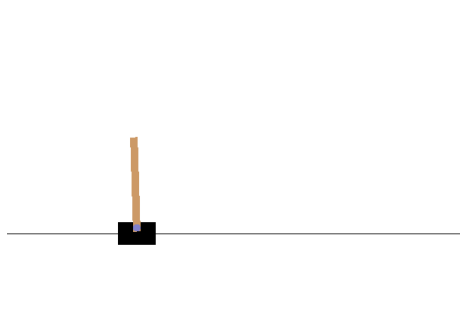

In [33]:
cartpole_env = Environment()
anim = cartpole_env.run()

In [34]:
HTML(anim)